# Introduction 


Body fat percentage is total mass of fat divided by total body mass. It is an important evaluation of a person's health level, too high or too low might cause diseases. There already some body fat calculators online. However, they usually require too many variables while some of them cannot be obtained easily. In this project, we try to construct a simple, moderately accurate and robust model to predict body fat percentage which obeys the "Rule of Thumb".


The dataset we use contains 252 male observations and 15 useful variables, including "BODYFAT" as response and some others as predictors. We have to construct a linear regression model with this dataset. First we have to clean the raw dataset. Then we fit a model to predict "BODYFAT", in order to obey "Rule of Thumb" we decide to choose two predictors and leave others out. After that, we construct, interpret and diagnose our final model. Finally we conclude the strengths and weaknesses of our final model. 

In [62]:
library(car)
library(leaps)
library(faraway)
library(glmnet)
library(ggplot2)
library(grid)
setwd("C:/Users/Mark Wei/Desktop/628/Project 2")

# Modeling

## Data cleaning

The first thing to do is to read the raw data and clean it (detect and delete abnormal observations). There are two criteria to extract abnormal observations. The first one is to delete those with abnormal feature values, such as a very short observation; The second one is to delete those with wrong relationship among some related values. For the second criterion there are two formulas, we have to check whether the points obey both of them: 

$$ BODYFAT \propto \frac{1}{DENSITY} \quad ; \quad ADIPOSITY(BMI) \propto \frac{WEIGHT}{{HEIGHT}^2}$$

In [39]:
DATA = read.csv("BodyFat.csv", row.names = 1)
data = DATA
data$IDNO = 1:length(data$BODYFAT)


##########siri##########
#####182,48,76,96#######
data$Bodyfat = 495*(1/data$DENSITY)-450
data$sirilabel = ifelse(abs(data$Bodyfat-data$BODYFAT)>sort(abs(data$Bodyfat-data$BODYFAT),decreasing = T)[5],data$IDNO,"")
plot.siri = ggplot(data = data, aes(x =IDNO,y = Bodyfat-BODYFAT, colour = factor(sirilabel)))+labs(title = "Density and Bodyfat Relationship")+ geom_point()+geom_text(data = data,aes(x = IDNO,y = Bodyfat-BODYFAT,label = sirilabel))

##########BMI##########
######42,163,221#######
data$BMI=703*(data$WEIGHT/(data$HEIGHT)^2)
data$bmilabel = ifelse(abs(data$BMI-data$ADIPOSITY)>sort(abs(data$BMI-data$ADIPOSITY),decreasing = T)[4],data$IDNO,"")
plot.bmi = ggplot(data = data, aes(x =IDNO,y = BMI-ADIPOSITY, colour = factor(bmilabel)))+labs(title = "Adiposity (BMI) Equation")+ geom_point()+geom_text(data = data,aes(x = IDNO,y = BMI-ADIPOSITY,label = bmilabel))

#we should get rid of the density 
DATA_new = DATA[, -2]
DATA_new = DATA_new[-c(42, 48, 76, 96, 163, 182, 221),]

In [3]:
########## Before removing the data points with large cook's distance##########
model0 = lm(BODYFAT ~ .,data = DATA[,-2])
data$cook = cooks.distance(model0)
data$cooklabel = ifelse(data$cook>0.02,data$IDNO,"")
plot.cook = ggplot(data = data, aes(x = IDNO, y = cook, colour = factor(cooklabel)))+ geom_point()+ labs(title = "Cook's Distance Before Cleaning") + geom_text(data = data,aes(x = IDNO,y = cook,label = cooklabel))

In [4]:
# Check the cook's distance one by one
#########cook###################     
k = 14 ###### number of variables
n = length(DATA$BODYFAT)
index = 1:n
index = index[-c(39,182,48,76,96,163,221,42)]
while(TRUE){
  a = qf(0.5,k,n-k)
  model1<- lm(BODYFAT ~ ., data = DATA_new)
  cook = cooks.distance(model1)
  if(sum(cook>0.5)>0){
    DATA_new = DATA_new[-which.max(cook),]
    index = index[-which.max(cook)]
    n = n-1
  }else{break}
}
out = setdiff(1:length(data$BODYFAT),index)
######cook.distance > F_0.5(k,n-k)####### 

# plot(model1, which = 4)
# deleted the possible outliers 39
# data[out,1:15]

By analysis, No.39 has too large weight ; No.42 is too short; No.48, 76, 96, 182 does not match the relationship between bodyfat and density; No.182 also has bodyfat 0 (abnormal value); No.42, 163, 221 don't obey the BMI equation. So we decide to delete eight points: No.39, 42, 48, 76, 96, 163, 182, 221. We remove them and make a new dataset. OutlierTest on the new set does not show any abnormality. Cook's distances also shrink to acceptable values after data cleaning.

In [5]:
data_clean = DATA_new[-39, ]#remove some potential outliers
data_clean = data.frame(scale(data_clean))#scale the data
write.csv(data_clean,"bodyfat_clean.csv",row.names = F)
#check the cook's distance again
model = lm(BODYFAT ~ ., data = data_clean)
#plot(model, which = 4)

#outlier test
outlierTest(model)

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferroni p
224 -2.555635            0.01125           NA

In [6]:
ndata = data[-c(out),]
model10 = lm(BODYFAT ~ .,data = DATA[-c(out),-2])
ndata$cook = cooks.distance(model10)
ndata$cooklabel = ifelse(ndata$cook>0.02,data$IDNO,"")
plot.cook.new = ggplot(data = ndata, aes(x = IDNO, y = cook, colour = factor(cooklabel)))+ geom_point()+labs(title = "Cook's Distance After Cleaning") +geom_text(data = ndata,aes(x = IDNO,y = cook,label = cooklabel))

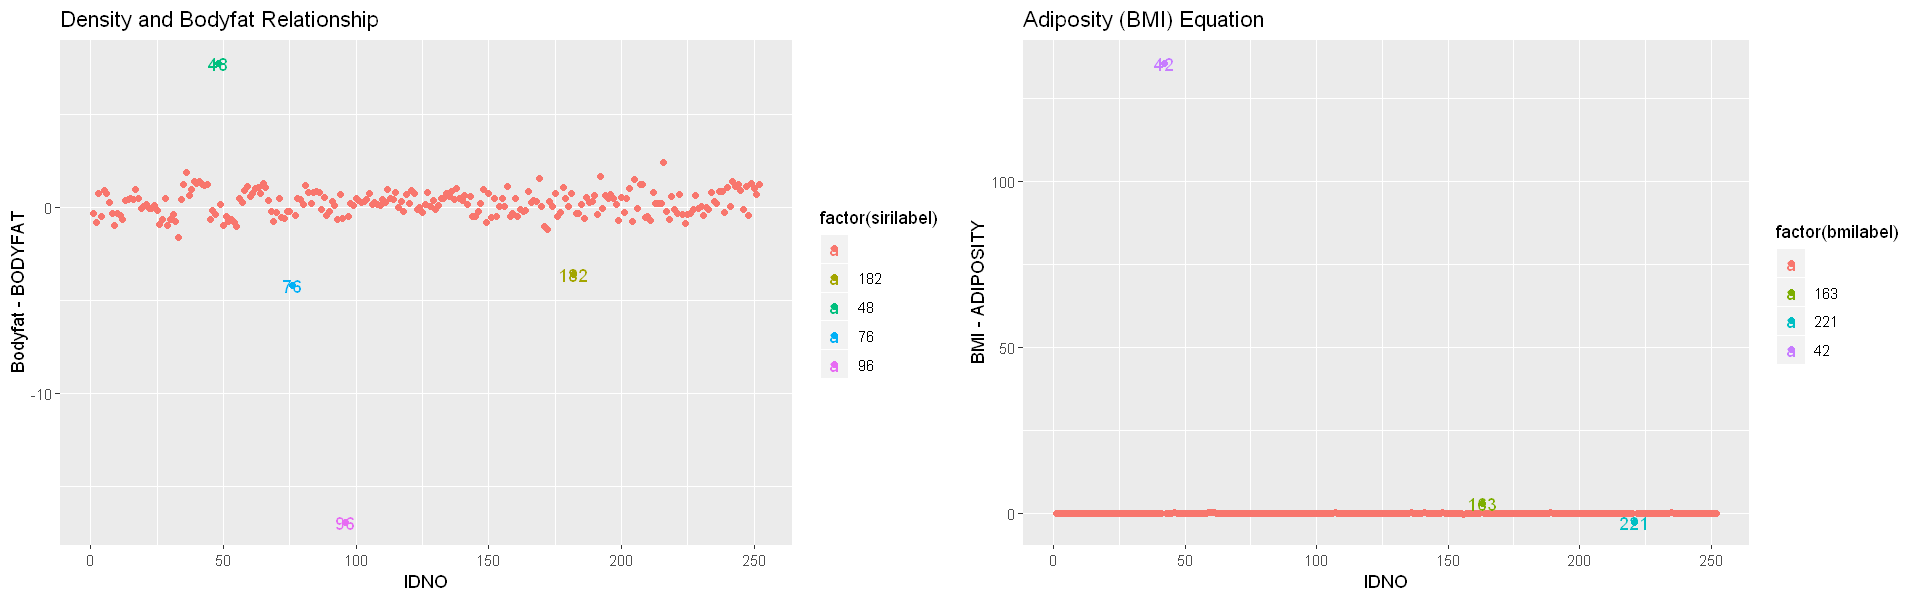

In [40]:
grid.newpage()
pushViewport(viewport(layout = grid.layout(1,2)))

print(plot.siri, vp = viewport(layout.pos.row = 1, layout.pos.col = 1))
print(plot.bmi,  vp = viewport(layout.pos.row = 1, layout.pos.col = 2))
# print(plot.cook, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
# print(plot.cook.new, vp = viewport(layout.pos.row = 2, layout.pos.col = 2))
options(repr.plot.width=16, repr.plot.height= 5)

## Model Selection

### Aggregation of different models

We did variable selection using these methods: Stepwise selection(AIC, BIC by backward/forward/both sides), Mallow's Cp, Adjusted R square and Lasso. And since our aim is to find a two-predictors model, we have to find out which of the predictors are frequently used. In all these nine methods, "ABDOMEN" and "WRIST" exists in all nine models, "WEIGHT" exists in eight models, other predictors exist in no more than four models. Therefore the most important three predictors are selected. We will continue our model by dropping at least one of these three predictors.

### Additional analysis

Summarizing the result of these models, we find that "ABDOMEN" is the most important predictor , followed by "WRIST" and "WEIGHT". Because of our "Rule of thumb" criterion, we decide to choose one of "WRIST" and "WEIGHT", then take it along with "ABDOMEN" as our two predictors. Suppose we set "Model 1" using ABDOMEN and WEIGHT to predict BODYFAT, and "Model 2" using ABDOMEN and WRIST to predict BODYFAT. "Model 3" only use ABDOMEN as predictor. We check multicolinearity by correlation and VIF test first.

In [61]:
#check the possible multicolinearity betweeen abdomen and wrist,weight
co = c(round(cor(data_clean$WEIGHT,data_clean$ABDOMEN),3), round(cor(data_clean$WRIST,data_clean$ABDOMEN),3))
cat("Correlation Coefficient (Model 1): ", round(cor(data_clean$WEIGHT,data_clean$ABDOMEN),3),
    "; Correlation Coefficient (Model 2): ", round(cor(data_clean$WRIST,data_clean$ABDOMEN),3), "\n", sep=" ")

cat("VIF of Model 1: ",round(vif(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = data_clean))[2],3), 
    "; VIF of Model 2: ", round(vif(lm(BODYFAT ~ ABDOMEN + WRIST, data = data_clean))[2],3), sep= " ")

Correlation Coefficient (Model 1):  0.873 ; Correlation Coefficient (Model 2):  0.603 
VIF of Model 1:  4.194 ; VIF of Model 2:  1.572

By VIF test, we suppose the predictors in "Model 1" are more correlated than "Model 2", so "WRIST" might be a better choice. Also, we can see the value of R-square are similar between two models. If we only use ABDOMEN to predict, the R-square indicates that's not reliable. So in order to reduce multicolinearity, we choose "Model 2" (ABDOMEN and WRIST) as our final model. 

In [9]:
s1 = summary(lm(BODYFAT ~ ABDOMEN + WRIST, data = data_clean))
s2 = summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = data_clean))
s3 = summary(lm(BODYFAT ~ ABDOMEN , data = data_clean))
ssq = round(c(s1$r.squared, s2$r.squared,s3$r.squared),3)
cat("The R-square value of Model 1,2,3 are ",ssq ,sep = ", ")

The R-square value of Model 1,2,3 are , 0.715, 0.724, 0.678

# Final Model Interpretation

To interpret our final model, Male Bodyfat percentage can be estimated by 0.73 abdomen(cm) minus 2.03 wrist(cm) and then substract 11.2. That is:
$$ Bodyfat(\%) = 0.73*Abdomen(cm)-2.03*Wrist(cm)-11.2 $$
For example, a male who has abdomen 80cm and wrist 18cm, his bodyfat percentage is around 10.66%.

## Diagnostics
Now we check modeling assumptions with plots. We can see the points approximately follows a normal distribution. They do not violate linear regression assumptions. So our final model is acceptable.

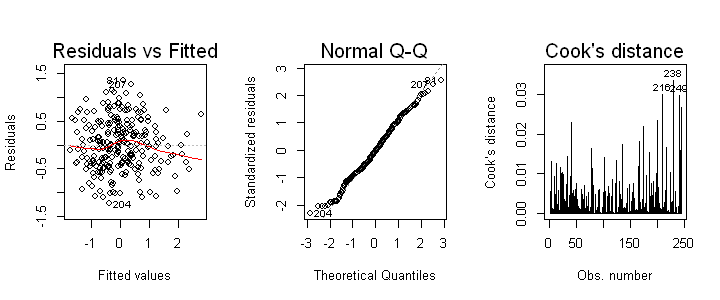

In [36]:
layout(matrix(c(1,2,3), 1, 3, byrow = TRUE))

final_model<-lm(BODYFAT ~ ABDOMEN + WRIST, data = data_clean)
plot(final_model,which=1)
plot(final_model,which=2)
plot(final_model,which=4)
options( repr.plot.width = 6, repr.plot.height = 2.5)

## Strengths and weakness 

Strengths of our Model:  
1. Our final model is simple and straightforward. The variables included for prediction is easy to get. It is also easy to calculate.  
2. The model is robust, it use the significant predictors that exist in most of models.  
3. The model is accurate as the adjusted R-squared is greater than 0.7.  

Weaknesses of our Model:   
1. We only consider two variables and ignored the interaction between these variables as a trade off between simplicity and accuracy. 
2. Our data sample only contains 252 observations, if the weight is too hig or too low, the prediction may not be so accurate.

## Conclusion

Our final model only contains two variables, abdomen and wrist. They are easy to measure so that the body calculator is easy and as accurate as possible. Our Shiny App also consider the limitation of our model, we only predict the bodyfat percentage of male and the abdomen and wrist number cannot be too large or too small in order to make the bodyfat percentage reasonable.  

# Contribution

GUANQI LU: Data cleaning and model building and jupyter notebook summary.  
QIAOCHU YU: Slides and plots using ggplot and jupyter notebook summary.  
HAOXIANG WEI:  Data analyzing and jupyter notebook summary.  
YI-HSUAN TSAI: Shiny App building and jupyter notebook summary.